In [30]:
import json
import numpy as np
from typing import List, Dict
from copy import deepcopy

def remove_price_outliers(data: List[Dict]) -> tuple[List[Dict], int]:
    prices = np.array([item['price'] for item in data])
    
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    valid_items = []
    removed = 0
    
    print(f"\nPrice statistics:")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    
    for item in data:
        price = item['price']
        if lower_bound <= price <= upper_bound:
            valid_items.append(item)
        else:
            removed += 1
    
    return valid_items, removed

def clean_invalid_records(data: List[Dict]) -> tuple[List[Dict], int]:
    valid_items = []
    removed = 0
    
    for item in data:
        name = item.get('name', '').strip()
        price = item.get('price', None)
        
        if not name or price is None or price == '':
            removed += 1
        else:
            valid_items.append(item)
            
    return valid_items, removed

def make_hashable(item: Dict) -> tuple:
    def convert_value(v):
        if isinstance(v, list):
            return tuple(sorted(v))
        if isinstance(v, dict):
            return make_hashable(v)
        return v

    return tuple(
        (k, convert_value(v)) 
        for k, v in sorted(item.items())
    )

def find_exact_duplicates(data: List[Dict]) -> tuple[List[Dict], int]:
    unique_items = []
    seen = set()
    duplicates = 0
    
    for item in data:
        item_tuple = make_hashable(item)
        
        if item_tuple not in seen:
            seen.add(item_tuple)
            unique_items.append(item)
        else:
            duplicates += 1
    
    return unique_items, duplicates

def find_name_duplicates(data: List[Dict]) -> tuple[List[Dict], int]:
    unique_items = []
    seen_names = set()
    duplicates = 0
    
    for item in data:
        name = item['name']
        
        if name not in seen_names:
            seen_names.add(name)
            unique_items.append(item)
        else:
            duplicates += 1
    
    return unique_items, duplicates

def process_duplicates(data: List[Dict]) -> List[Dict]:
    working_data = deepcopy(data)
    
    print("\n=== Stage 1: Removing invalid records ===")
    cleaned_data, invalid_count = clean_invalid_records(working_data)
    print(f"Invalid records removed: {invalid_count}")
    
    print("\n=== Stage 2: Removing price outliers ===")
    no_outliers_data, outliers_count = remove_price_outliers(cleaned_data)
    print(f"Price outliers removed: {outliers_count}")
    
    print("\n=== Stage 3: Removing exact duplicates ===")
    deduped_data, exact_dupes = find_exact_duplicates(no_outliers_data)
    print(f"Exact duplicates removed: {exact_dupes}")
    
    print("\n=== Stage 4: Removing name-based duplicates ===")
    final_data, name_dupes = find_name_duplicates(deduped_data)
    print(f"Name-based duplicates removed: {name_dupes}")
    
    print(f"\nSummary:")
    print(f"Original records: {len(data)}")
    print(f"Invalid records removed: {invalid_count}")
    print(f"Price outliers removed: {outliers_count}")
    print(f"Duplicates removed: {exact_dupes + name_dupes}")
    print(f"Final records: {len(final_data)}")
    
    return final_data

In [32]:
import pandas as pd

with open('tutors-final.json', 'r', encoding='utf-8') as file:
        data = json.load(file)

clean_data = process_duplicates(data)
    
with open('tutors_cleaned.json', 'w', encoding='utf-8') as file:
    json.dump(clean_data, file, ensure_ascii=False, indent=2)

df = pd.DataFrame(clean_data)

# Handle the 'subjects' list column by joining with commas
df['subjects'] = df['subjects'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Save to CSV with UTF-8 encoding
df.to_csv('tutors_cleaned.csv', index=False, encoding='utf-8-sig')



=== Stage 1: Removing invalid records ===
Invalid records removed: 0

=== Stage 2: Removing price outliers ===

Price statistics:
Q1: 3000.00
Q3: 5000.00
IQR: 2000.00
Lower bound: 0.00
Upper bound: 8000.00
Price outliers removed: 91

=== Stage 3: Removing exact duplicates ===
Exact duplicates removed: 67

=== Stage 4: Removing name-based duplicates ===
Name-based duplicates removed: 295

Summary:
Original records: 2091
Invalid records removed: 0
Price outliers removed: 91
Duplicates removed: 362
Final records: 1638


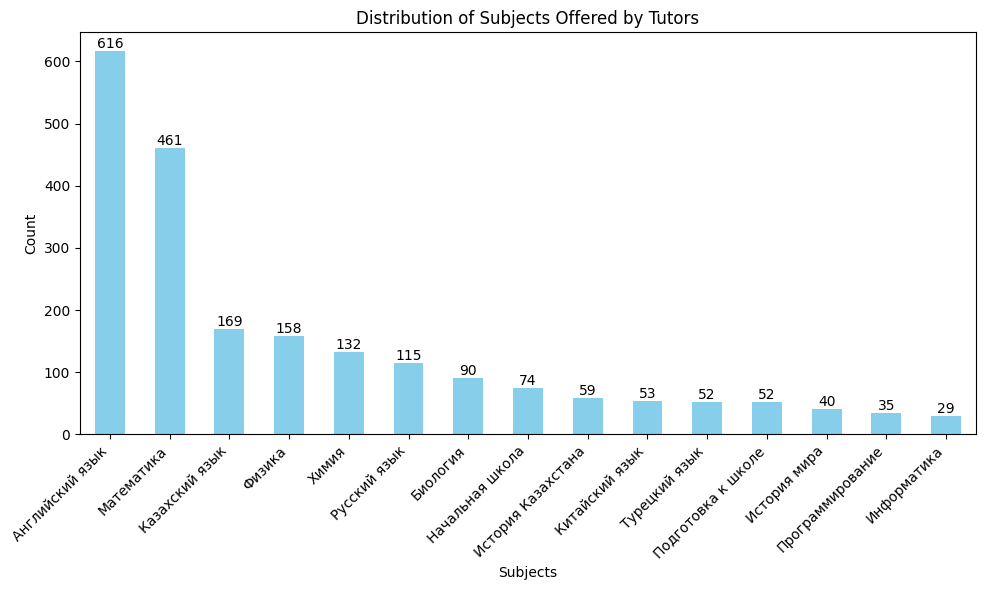

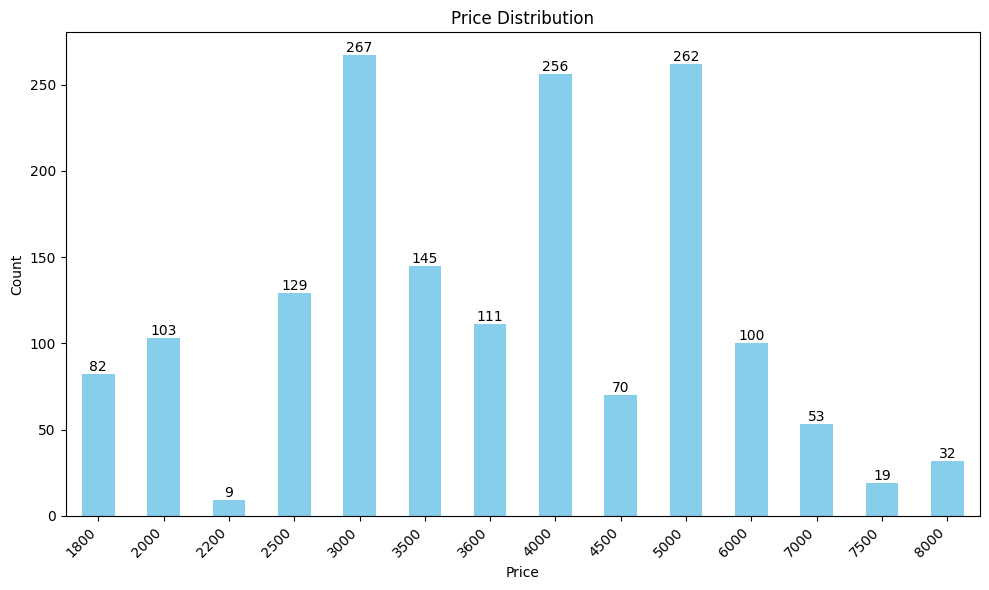

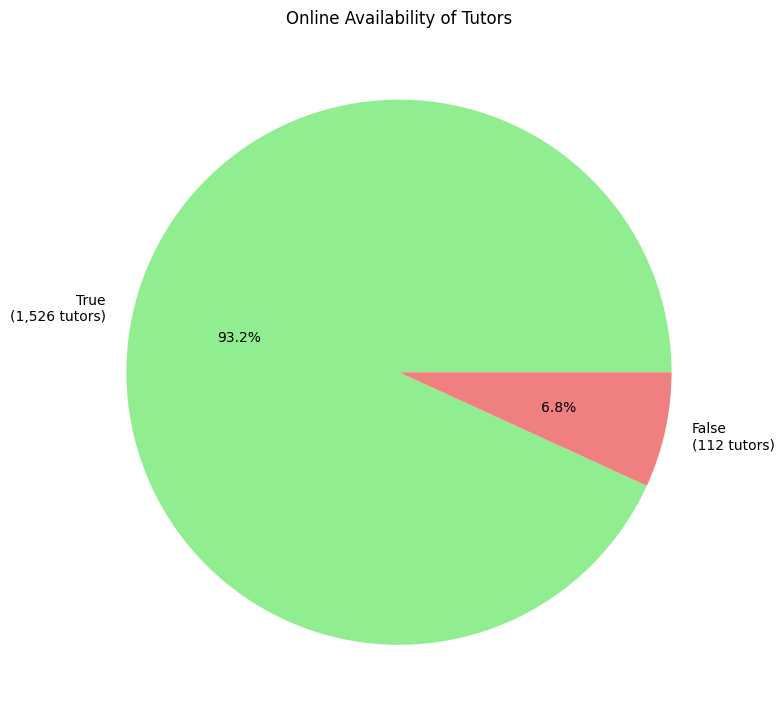

In [53]:
import matplotlib.pyplot as plt

df = pd.DataFrame(clean_data)

df["reviewCount"] = pd.to_numeric(df["reviewCount"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["experience_years"] = df["experience"].str.extract(r"(\d+)").astype(float)
df["subjects_count"] = df["subjects"].apply(len)

subjects = df.explode("subjects")["subjects"].value_counts().head(15)
online_availability = df["canWorkOnline"].value_counts()

plt.figure(figsize=(10, 6))
ax = subjects.plot(kind="bar", color="skyblue")
plt.title("Distribution of Subjects Offered by Tutors")
plt.xlabel("Subjects")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(subjects):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Sort the price counts by ascending order
sorted_counts = df['price'].value_counts().sort_index()

# Create the bar chart
ax = sorted_counts.plot(kind="bar", color="skyblue")

# Add titles and labels
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Annotate the bars with their counts
for i, v in enumerate(sorted_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 8))
plt.pie(online_availability, 
        labels=[f'{label}\n({value:,} tutors)' for label, value in online_availability.items()],
        autopct='%1.1f%%',
        colors=["lightgreen", "lightcoral"])
plt.title("Online Availability of Tutors")
plt.tight_layout()
plt.show()



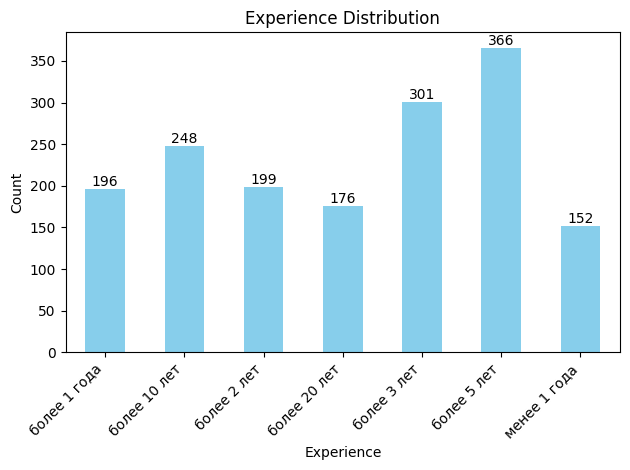

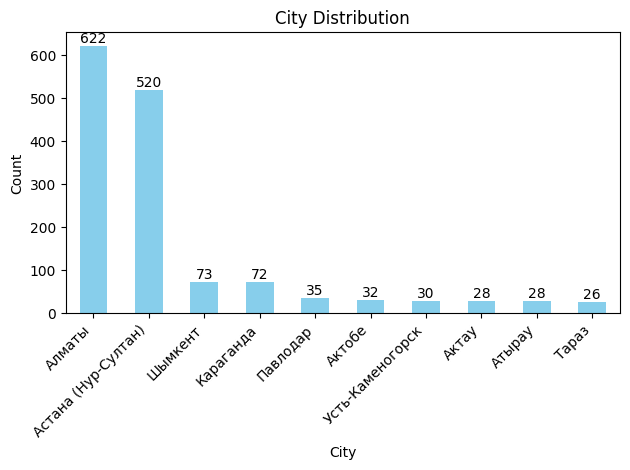

In [59]:
sorted_counts = df['experience'].value_counts().sort_index()

ax = sorted_counts.plot(kind="bar", color="skyblue")

plt.title("Experience Distribution")
plt.xlabel("Experience")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(sorted_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

sorted_counts = df['city'].value_counts().sort_values(ascending=False).head(10)

ax = sorted_counts.plot(kind="bar", color="skyblue")

plt.title("City Distribution")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(sorted_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()
